In [3]:
# 셀 1: 라이브러리 임포트
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import LSTM, Linear
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import re
import seaborn as sns
import matplotlib.pyplot as plt

# 주피터 노트북에서 그래프 표시 설정
%matplotlib inline

In [4]:
# 데이터 경로 설정
base_path = './data/'

anomaly_label_path = base_path + 'anomaly_label.csv'
event_occurrence_matrix_path = base_path + 'Event_occurrence_matrix.csv'
log_templates_path = base_path + 'HDFS.log_templates.csv'
event_traces_path = base_path + 'Event_traces.csv'
error_descriptions_path = base_path + 'Detailed_Type_Error_Descriptions.csv'

# 데이터 로드
anomaly_label = pd.read_csv(anomaly_label_path)
event_occurrence_matrix = pd.read_csv(event_occurrence_matrix_path)
log_templates = pd.read_csv(log_templates_path)
event_traces = pd.read_csv(event_traces_path)
error_descriptions = pd.read_csv(error_descriptions_path)

# 라벨 인코딩
label_dict = {'Normal': 0, 'Anomaly': 1}
anomaly_label['Label'] = anomaly_label['Label'].map(label_dict)

# 이벤트 ID 매핑
event_id_to_template = dict(zip(log_templates['EventId'], log_templates['EventTemplate']))
event_ids = log_templates['EventId'].unique()
event_id_to_index = {event_id: idx for idx, event_id in enumerate(event_ids)}


# 필요 없는 열 제거 
event_occurrence_matrix = event_occurrence_matrix.drop(columns=['Label', 'Type'], errors='ignore')  #타입추가

event_occurrence_matrix = event_occurrence_matrix.fillna(0)


# 문자열 형태의 리스트를 실제 리스트로 변환
def parse_features(s):
    if not s or pd.isna(s):
        return []
    return re.findall(r'E\d+', s)

def parse_time_intervals(s):
    if not s or pd.isna(s):
        return []
    s = s.strip('[]')
    elements = s.split(',')
    elements = [float(e.strip()) for e in elements if e.strip()]
    return elements

event_traces['Features'] = event_traces['Features'].apply(parse_features)
event_traces['TimeInterval'] = event_traces['TimeInterval'].apply(parse_time_intervals)

# 'BlockId' 데이터 타입 통일
anomaly_label['BlockId'] = anomaly_label['BlockId'].astype(str)
event_traces['BlockId'] = event_traces['BlockId'].astype(str)

# 데이터 병합
merged_data = pd.merge(event_traces, anomaly_label.rename(columns={'Label': 'AnomalyLabel'}), on='BlockId', how='inner')

# Type 정보가 없는 경우 NaN을 대체
merged_data['Type'] = merged_data['Type'].fillna(-1).astype(int)


In [5]:
def create_graph(block_events):
    nodes = []
    edge_index = [[], []]

    # 이벤트 ID를 인덱스로 변환하여 노드 리스트 생성
    for event_id in event_ids:
        node_idx = event_id_to_index[event_id]
        nodes.append(node_idx)

    # 엣지 생성 (이벤트 시퀀스에 따라)
    for i in range(len(block_events) - 1):
        src = event_id_to_index[block_events[i]]
        dst = event_id_to_index[block_events[i + 1]]
        edge_index[0].append(src)
        edge_index[1].append(dst)

    # 텐서로 변환
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.eye(len(event_ids))  # 노드 특징 (원-핫 인코딩)
    return x, edge_index


In [6]:
graph_data_list = []

for idx, row in merged_data.iterrows():
    label = row['AnomalyLabel']
    events = row['Features']

    # 이벤트가 1개 이하인 경우 제외
    if len(events) <= 1:
        continue

    # 그래프 생성
    x, edge_index = create_graph(events)

    # 그래프 데이터 객체 생성
    data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    graph_data_list.append(data)


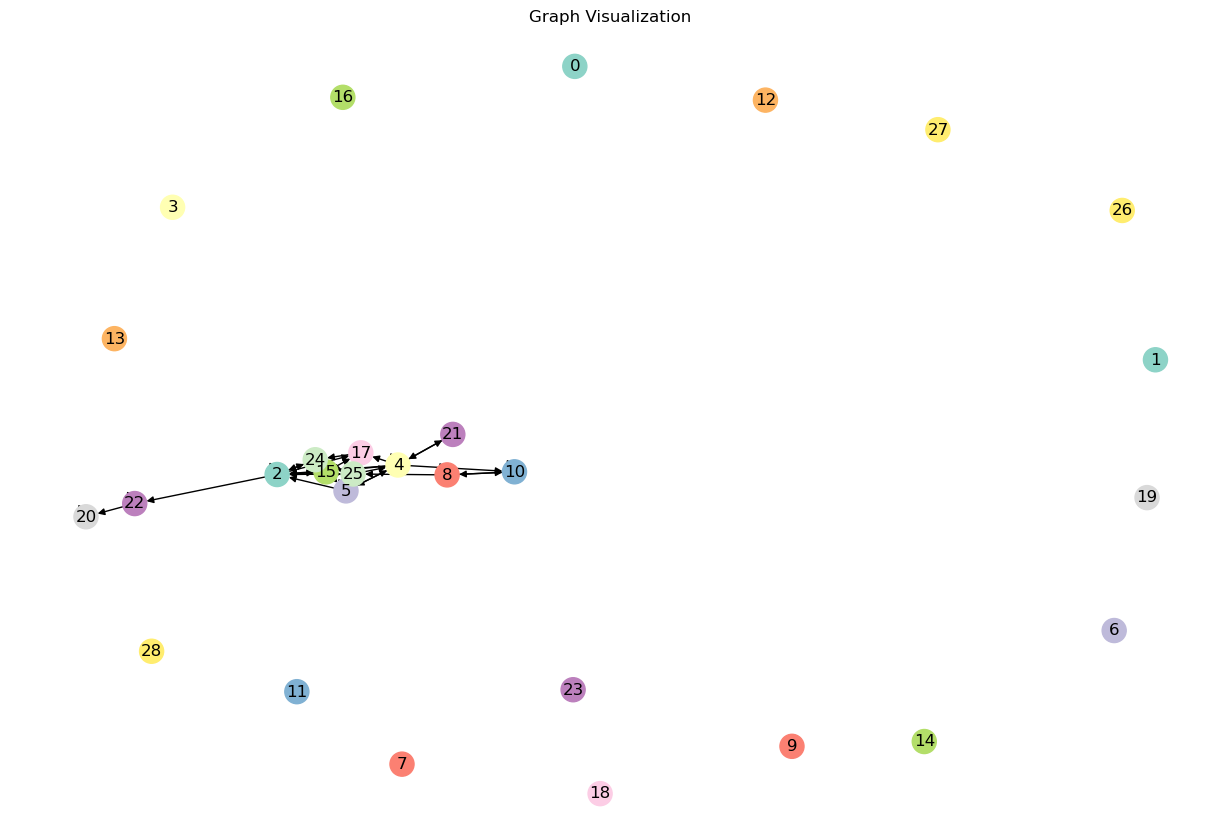

In [7]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# 그래프 데이터 중 하나 선택
data = graph_data_list[0]

# NetworkX 그래프로 변환
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

# 그래프 레이아웃 설정
pos = nx.spring_layout(G, seed=42)

# 노드 특징에 따라 색상 지정
node_colors = [i for i in range(len(G.nodes()))]

# 그래프 그리기
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Set3)
plt.title('Graph Visualization')
plt.show()


In [8]:
# 첫 번째 그래프 데이터가 어떤 BlockId에 해당하는지 확인
first_graph_index = 0  # 첫 번째 그래프의 인덱스
for idx, row in merged_data.iterrows():
    events = row['Features']
    if len(events) > 1:  # create_graph에서 사용된 필터 조건과 일치시킴
        if first_graph_index == 0:
            print(f"graph_data_list[0]에 해당하는 BlockId: {row['BlockId']}")
            break
        first_graph_index -= 1


graph_data_list[0]에 해당하는 BlockId: blk_-1608999687919862906


In [9]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout=0.6):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.lin = Linear(hidden_channels, 2)  # 그래프 분류를 위한 출력 레이어
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch): #이게 진짜임..우리는 이걸 쓰는거야. init는 디폴트 호출 때 사용되는 거다잉.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        x = global_mean_pool(x, batch)  # 그래프 임베딩 생성
        x = self.dropout3(x)
        x = self.lin(x)
        return x

    def get_node_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        return x  # 노드 임베딩 반환

print("GNN 모델 정의 완료.")

GNN 모델 정의 완료.


In [10]:
from torch_geometric.loader import DataLoader

batch_size = 32

gnn_train_data, gnn_test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

gnn_train_loader = DataLoader(gnn_train_data, batch_size=batch_size, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_data, batch_size=batch_size, shuffle=False)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화
gnn_model = GNN(num_node_features=len(event_ids), hidden_channels=64, dropout=0.6).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for data in gnn_train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(gnn_train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/10], Loss: 0.1471
Epoch [2/10], Loss: 0.1306
Epoch [3/10], Loss: 0.1254
Epoch [4/10], Loss: 0.1186
Epoch [5/10], Loss: 0.1136
Epoch [6/10], Loss: 0.1059
Epoch [7/10], Loss: 0.0974
Epoch [8/10], Loss: 0.0890
Epoch [9/10], Loss: 0.0816
Epoch [10/10], Loss: 0.0754


In [11]:
gnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in gnn_test_loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        _, pred = torch.max(out, 1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
accuracy = correct / total
print(f'GNN Test Accuracy: {accuracy:.4f}')


GNN Test Accuracy: 0.9826


In [12]:
data_list = []

gnn_model.eval()

for idx, row in merged_data.iterrows():
    block_id = row['BlockId']
    label = row['AnomalyLabel']
    events = row['Features']
    error_type = row['Type']

    # 이벤트가 1개 이하인 경우 제외
    if len(events) <= 1:
        continue

    # 그래프 생성
    x, edge_index = create_graph(events)
    x = x.to(device)
    edge_index = edge_index.to(device)

    with torch.no_grad():
        node_embeddings = gnn_model.get_node_embeddings(x, edge_index)  # 노드 임베딩 추출

    # 이벤트 시퀀스에 따른 임베딩 추출
    seq_embeddings = node_embeddings[[event_id_to_index[e] for e in events if e in event_id_to_index]]

    # 데이터 추가 (Type 정보 포함)
    data_list.append((seq_embeddings.cpu().numpy(), label, block_id, error_type))


In [13]:
print("Node Embeddings Shape:", node_embeddings.shape)
# 노드 인덱스와 이벤트 ID 매핑
index_to_event_id = {v: k for k, v in event_id_to_index.items()}

# 첫 번째 5개의 노드 임베딩 출력
for i in range(5):
    event_id = index_to_event_id[i]
    embedding = node_embeddings[i].cpu().numpy()
    print(f"Event ID: {event_id}, Embedding: {embedding}")
# 임베딩의 평균과 표준편차 계산
embeddings_np = node_embeddings.cpu().numpy()
mean = embeddings_np.mean()
std = embeddings_np.std()
print(f"Embeddings Mean: {mean:.4f}, Std: {std:.4f}")


Node Embeddings Shape: torch.Size([29, 64])
Event ID: E1, Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Event ID: E2, Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Event ID: E3, Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Event ID: E4, Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Event ID: E5, Embedding: [0.01358117 0.37481666 0.5524946  0.26344457 0.

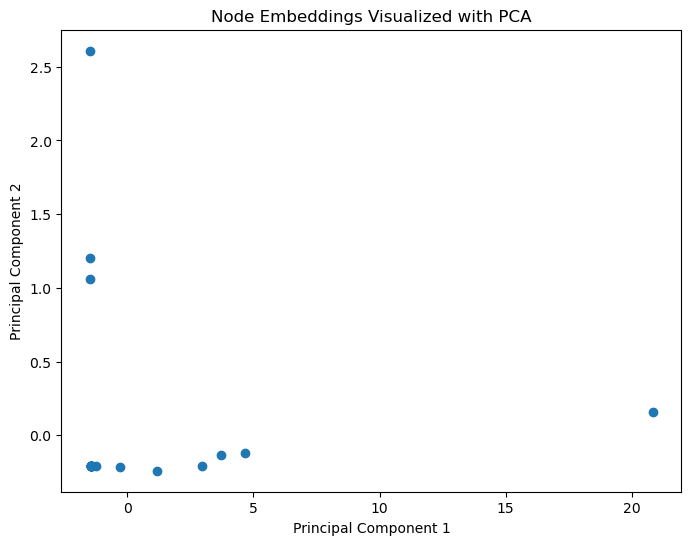

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 임베딩을 NumPy 배열로 변환
embeddings_np = node_embeddings.cpu().numpy()

# PCA로 2차원 축소
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# 이벤트 ID 라벨링
event_labels = [index_to_event_id[i] for i in range(len(embeddings_2d))]

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.title('Node Embeddings Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


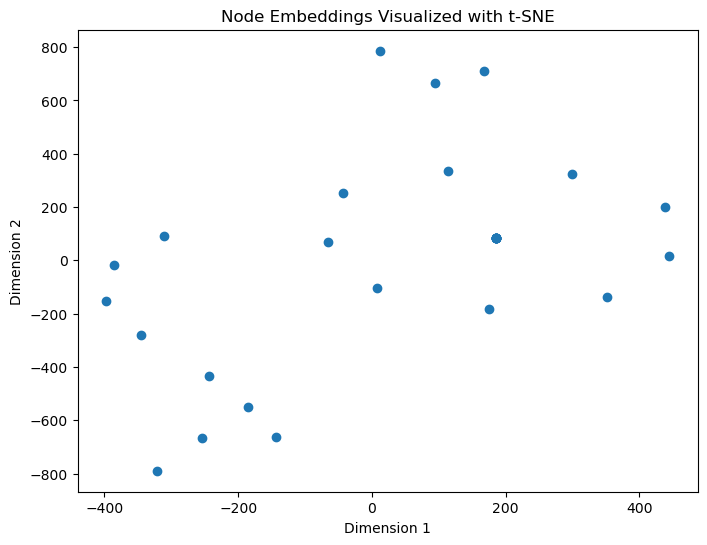

In [15]:
from sklearn.manifold import TSNE

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


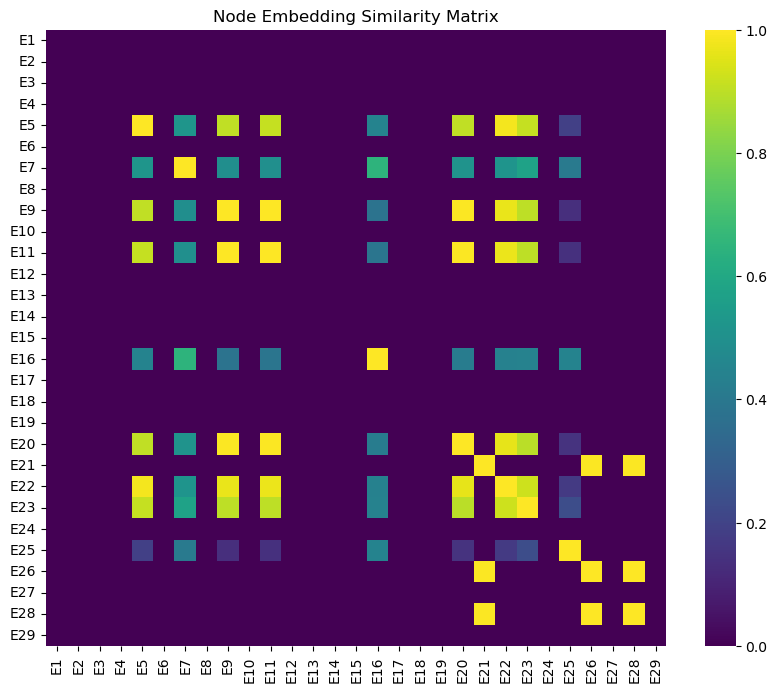

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# 코사인 유사도 행렬 계산
similarity_matrix = cosine_similarity(embeddings_np)

# 시각화
plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, xticklabels=event_labels, yticklabels=event_labels, cmap='viridis')
plt.title('Node Embedding Similarity Matrix')
plt.show()


In [17]:
# 임베딩 저장
np.save('node_embeddings.npy', embeddings_np)

# 저장된 임베딩 불러오기
loaded_embeddings = np.load('node_embeddings.npy')


In [18]:
for i in range(100):
    # 블록의 임베딩 시퀀스 확인
    seq_embeddings, label, block_id, error_type = data_list[i]

    print(f"Block ID: {block_id}")
    print(f"Label: {label}")
    print(f"Error Type: {error_type}")
    print("Sequence Embeddings Shape:", seq_embeddings.shape)
    print("Sequence Embeddings:")
    print(seq_embeddings)


Block ID: blk_-1608999687919862906
Label: 0
Error Type: -1
Sequence Embeddings Shape: (269, 64)
Sequence Embeddings:
[[0.         0.         0.         ... 0.25108084 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.25108084 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Block ID: blk_7503483334202473044
Label: 0
Error Type: -1
Sequence Embeddings Shape: (22, 64)
Sequence Embeddings:
[[0.33124477 0.45560586 0.55714077 ... 0.         0.32226685 0.3864271 ]
 [0.33124477 0.45560586 0.55714077 ... 0.         0.32226685 0.3864271 ]
 [0.33124477 0.45560586 0.55714077 ... 0.         0.32226685 0.3864271 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0. 

C:\Users\jihun\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


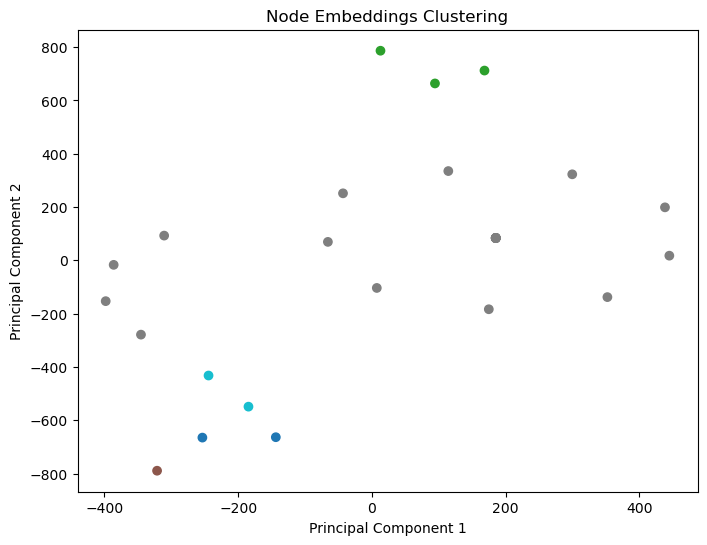

In [19]:
from sklearn.cluster import KMeans

# 클러스터링 수행 (예: 5개 군집)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# 시각화 (PCA 적용 후 클러스터링 결과 표시)
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=clusters, cmap='tab10')
plt.title('Node Embeddings Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


C:\Users\jihun\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


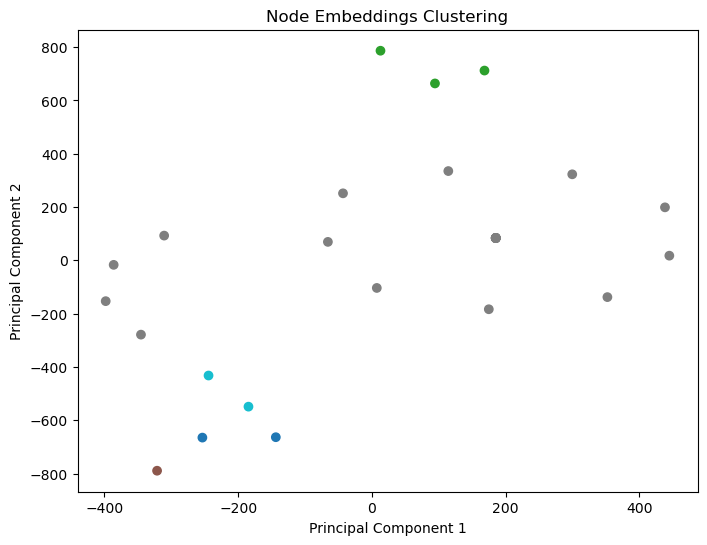

In [20]:
from sklearn.cluster import KMeans

# 클러스터링 수행 (예: 5개 군집)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# 시각화 (PCA 적용 후 클러스터링 결과 표시)
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=clusters, cmap='tab10')
plt.title('Node Embeddings Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [72]:
from torch.utils.data import Dataset

class CustomSequenceDataset(Dataset):
    def __init__(self, data_list, max_seq_len=None):
        self.data_list = data_list
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        seq_embeddings, label, block_id, error_type = self.data_list[idx]
        seq = torch.tensor(seq_embeddings, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        error_type = torch.tensor(error_type, dtype=torch.long)

        # 시퀀스 길이 제한
        if self.max_seq_len is not None and seq.shape[0] > self.max_seq_len:
            seq = seq[:self.max_seq_len]

        return seq, label, error_type


In [74]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    types = torch.tensor([item[2] for item in batch], dtype=torch.long)
    
    # 배치에서 시퀀스 패딩
    sequences_padded = pad_sequence(sequences, batch_first=True)
    return sequences_padded, labels, types


In [76]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes_label, num_classes_type, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # 분류기 레이어
        self.fc_label = nn.Linear(hidden_size, num_classes_label)  # 이상 여부 예측용
        self.fc_type = nn.Linear(hidden_size, num_classes_type)    # 오류 유형 예측용
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 초기 hidden 및 cell 상태 설정
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 전방향 패스
        out, _ = self.lstm(x, (h0, c0))

        # Dropout 적용
        out = self.dropout(out)

        # 마지막 타임스텝의 출력값을 사용하여 분류
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # 두 개의 출력 생성
        label_output = self.fc_label(out)  # 이상 여부 예측
        type_output = self.fc_type(out)    # 오류 유형 예측

        return label_output, type_output


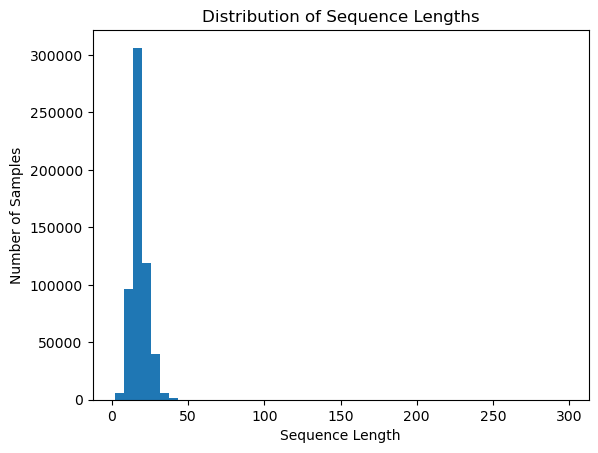

In [78]:
# 시퀀스 길이 계산
sequence_lengths = [seq_embeddings.shape[0] for seq_embeddings, _, _, _ in data_list]

# 히스토그램으로 분포 확인
import matplotlib.pyplot as plt

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [79]:
from torch.utils.data import DataLoader, random_split

# 최대 시퀀스 길이 설정
max_seq_len = 100

# Dataset 생성
dataset = CustomSequenceDataset(data_list, max_seq_len=max_seq_len)

# Train/Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 배치 크기 조절 
batch_size = 32

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [89]:
# LSTM 모델 초기화 (기존과 동일)
# LSTM 모델 초기화 (수정된 부분 포함)
input_size = data_list[0][0].shape[1]  # 노드 임베딩의 크기 (예: 64)
hidden_size = 128
num_layers = 2
num_classes_label = 2  # 정상, 비정상
types = [error_type for _, _, _, error_type in data_list]
# types를 텐서로 변환
types_tensor = torch.tensor(types, dtype=torch.long)
num_classes_type = types_tensor.max().item() + 1  # Type 클래스 수

# LSTM 모델 생성
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes_label, num_classes_type, dropout=0.2).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)
criterion_label = nn.CrossEntropyLoss()
criterion_type = nn.CrossEntropyLoss()

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    for batch_inputs, batch_labels, batch_types in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        batch_types = batch_types.to(device)

        optimizer.zero_grad()
        label_outputs, type_outputs = lstm_model(batch_inputs)  # LSTM은 (batch, seq_len, feature_size)

        # 손실 계산
        loss_label = criterion_label(label_outputs, batch_labels)
        # 정상인 경우(Type이 -1)에는 오류 유형 손실 계산하지 않음
        valid_indices = (batch_types != -1)
        if valid_indices.any():
            loss_type = criterion_type(type_outputs[valid_indices], batch_types[valid_indices])
            loss = loss_label + loss_type
        else:
            loss = loss_label

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/10], Loss: 0.6663
Epoch [2/10], Loss: 0.3533
Epoch [3/10], Loss: 0.2940
Epoch [4/10], Loss: 0.2206
Epoch [5/10], Loss: 0.1746
Epoch [6/10], Loss: 0.1505
Epoch [7/10], Loss: 0.1347
Epoch [8/10], Loss: 0.1283
Epoch [9/10], Loss: 0.1112
Epoch [10/10], Loss: 0.1054


LSTM Test Accuracy (Label): 0.9974
Classification Report (Label):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    111513
     Anomaly       0.95      0.96      0.96      3500

    accuracy                           1.00    115013
   macro avg       0.98      0.98      0.98    115013
weighted avg       1.00      1.00      1.00    115013



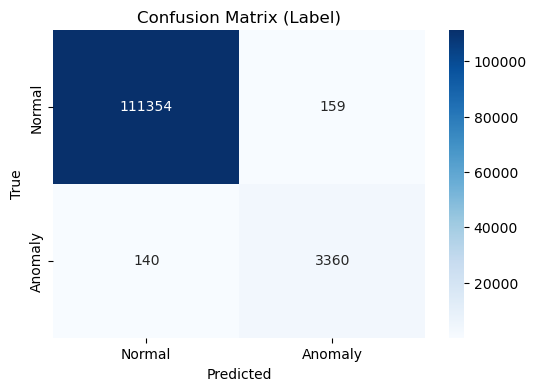

Classification Report (Type):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       557
           1       0.93      0.95      0.94       167
           3       1.00      1.00      1.00       586
           4       0.99      0.97      0.98       260
           5       0.95      0.96      0.96       894
           7       0.97      0.95      0.96       110
           8       0.00      0.00      0.00        16
           9       0.60      1.00      0.75         6
          10       0.00      0.00      0.00         1
          12       0.76      0.56      0.64        34
          13       0.00      0.00      0.00         3
          16       0.60      0.60      0.60         5
          18       0.00      0.00      0.00         6
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          21       0.89      0.83      0.86       152
          22       0.00      0.00      0.00        

C:\Users\jihun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jihun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jihun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


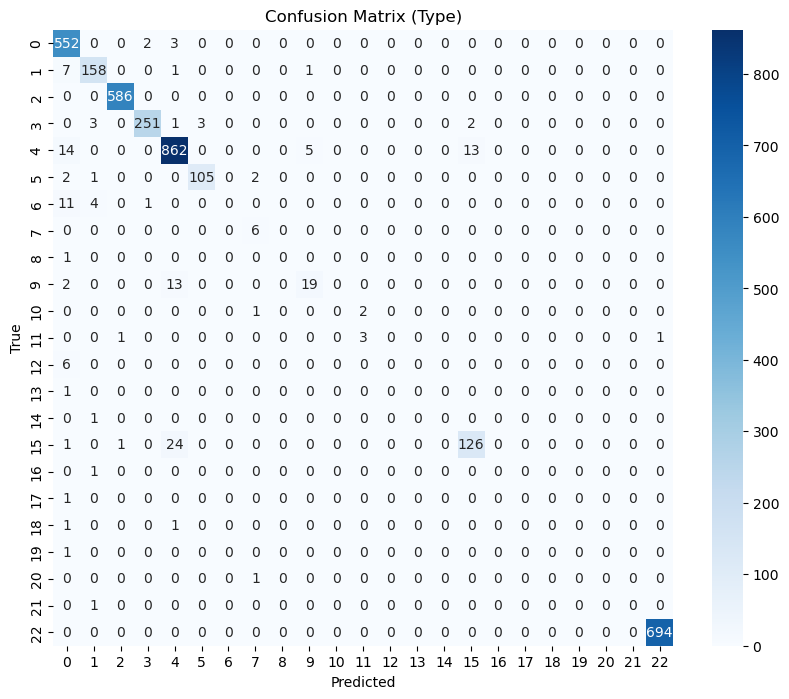

In [90]:
# 모델 평가
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# 모델 평가
lstm_model.eval()
correct_label = 0
total = 0

all_label_preds = []
all_label_true = []

all_type_preds = []
all_type_true = []

with torch.no_grad():
    for batch_inputs, batch_labels, batch_types in test_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        batch_types = batch_types.to(device)

        label_outputs, type_outputs = lstm_model(batch_inputs)

        # 이상 여부 예측
        _, label_predicted = torch.max(label_outputs.data, 1)
        correct_label += (label_predicted == batch_labels).sum().item()

        all_label_preds.extend(label_predicted.cpu().numpy())
        all_label_true.extend(batch_labels.cpu().numpy())

        # 오류 유형 예측 (비정상인 경우만)
        valid_indices = (batch_types != -1)
        if valid_indices.any():
            _, type_predicted = torch.max(type_outputs.data[valid_indices], 1)
            all_type_preds.extend(type_predicted.cpu().numpy())
            all_type_true.extend(batch_types[valid_indices].cpu().numpy())

        total += batch_labels.size(0)

    accuracy_label = correct_label / total
    print(f'LSTM Test Accuracy (Label): {accuracy_label:.4f}')

    # Classification Report (Label)
    print("Classification Report (Label):")
    print(classification_report(all_label_true, all_label_preds, target_names=['Normal', 'Anomaly']))

    # Confusion Matrix (Label)
    cm_label = confusion_matrix(all_label_true, all_label_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_label, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Label)')
    plt.show()

    # Classification Report (Type)
    if all_type_true:
        print("Classification Report (Type):")
        print(classification_report(all_type_true, all_type_preds))

        # Confusion Matrix (Type)
        cm_type = confusion_matrix(all_type_true, all_type_preds)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm_type, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Type)')
        plt.show()

In [91]:
# 오류 설명 매핑 딕셔너리 생성
error_descriptions['Type'] = error_descriptions['Type'].astype(int)
error_type_to_description = dict(zip(error_descriptions['Type'], error_descriptions['ErrorDescription']))

# 임의의 100개 데이터에 대한 정보 출력
import random

# 데이터 리스트에서 임의의 100개 샘플 선택
sample_data_list = random.sample(data_list, 100)

for seq_embeddings, label, block_id, error_type in sample_data_list:
    print(f"Block ID: {block_id}")
    print(f"Label: {'Anomaly' if label == 1 else 'Normal'}")

    if label == 1 and error_type != -1:
        error_description = error_type_to_description.get(error_type, 'Unknown Error')
        print(f"Error Type: {error_type}")
        print(f"Error Description: {error_description}")
    else:
        print("Error Type: N/A")
        print("Error Description: N/A")

    print("Sequence Embeddings Shape:", seq_embeddings.shape)
    print("Sequence Embeddings (First 2 embeddings):")
    print(seq_embeddings[:2])  # 시퀀스 임베딩의 처음 2개만 출력
    print("-" * 80)

Block ID: blk_-3410620510178510781
Label: Normal
Error Type: N/A
Error Description: N/A
Sequence Embeddings Shape: (19, 64)
Sequence Embeddings (First 2 embeddings):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02498341 0.1231153  0.16584377 0.03177106 0.22268893 0.1597876
  0.08343458 0.11136685 0.12777768 0.096229   0.22221822 0.09977381
  0.15617906 0.         0.         0.13947271 0.0023

In [105]:
# 모델 저장
torch.save(gnn_model.state_dict(), 'gnn_model.pth')
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

# 모델 로딩
gnn_model.load_state_dict(torch.load('gnn_model.pth'))
lstm_model.load_state_dict(torch.load('lstm_model.pth'))

C:\Users\jihun\AppData\Local\Temp\ipykernel_12856\2872379116.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn_model.load_state_dict(torch.load('gnn_model.pth'))
C:\Us

<All keys matched successfully>

In [103]:
torch.save(gnn_model.state_dict(), 'gnn_model.pth')
torch.save(lstm_model.state_dict(), 'lstm_model.pth')
